<a href="https://colab.research.google.com/github/megasiska86/Neural-Network-Repository/blob/master/densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
!cp '/content/drive/My Drive/datasetd.pth' '/content/datasetd.pth'

In [0]:
# Jalankan sel ini untuk memasang Google Drive Anda.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ColorJitter(), transforms.Grayscale(num_output_channels=3),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=True, transform=transform,
                                        download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=False, transform=transform,
                                       download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=0)
trainset1,validset = torch.utils.data.random_split(trainset, [50000,10000])
trainloader1=torch.utils.data.DataLoader(trainset1, batch_size=8,shuffle=True, num_workers=0)
validloader=torch.utils.data.DataLoader(validset, batch_size=8,shuffle=True, num_workers=0)

classes = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
torch.save({'trainset1': trainset1, 'validset': validset,'trainloader1': trainloader1, 'validloader': validloader,'testset': testset, 'testloader':testloader}, 'datasetd.pth')

In [0]:
checkpoint = torch.load('datasetd.pth')
trainset1 = checkpoint['trainset1']
validset = checkpoint['validset']
trainloader1 = checkpoint['trainloader1']
validloader =checkpoint['validloader']
testset = checkpoint['testset']
testloader =checkpoint['testloader']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
model=models.densenet121(pretrained=True)
model.classifier=nn.Sequential(nn.Linear(1024,10),nn.LogSoftmax(1))
model=model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 48570965.64it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
optimizer=optim.SGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.006, step_size_up=18750)
#loss_fn = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [0]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
train_acc_list=[]
test_acc_list=[]
start_epoch=0
e=5

In [0]:
#!cp '/content/drive/My Drive/dense.pth' '/content/dense.pth'

In [0]:
for epoch in range(start_epoch,15):
    #exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 2100) % (2100 * 2100) == 0:
            print(i*10, '/ 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
                
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses.append(m_t_l)
    mean_valid_losses.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list.append(accuracy_v)
    train_acc_list.append(accuracy_t)
    
    
        #save
    #torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'train loss': mean_train_losses,'train acc': train_acc_list, 'valid loss':mean_valid_losses, 'valid acc': valid_acc_list}, 'dense.pth')
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'train loss': mean_train_losses,'train acc': train_acc_list, 'valid loss':mean_valid_losses, 'valid acc': valid_acc_list}, 'dense1.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f}% valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
b_val_acc=np.max(valid_acc_list)
b_val_loss=np.min(mean_valid_losses)
b_train_acc=np.max(train_acc_list)
b_train_loss=np.min(mean_train_losses)
#torch.save({'best val acc':b_val_acc,'best val loss':b_val_loss,'best train acc':b_train_acc,'best train loss':b_train_loss},'bestd.pth')
torch.save({'best val acc':b_val_acc,'best val loss':b_val_loss,'best train acc':b_train_acc,'best train loss':b_train_loss},'bestd1.pth')
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list),np.min(mean_train_losses)))

0 / 50000
21000 / 50000
42000 / 50000
epoch : 11, train loss : 0.0721, train acc : 97.34% valid loss : 0.2935, valid acc : 91.84%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 12, train loss : 0.0693, train acc : 97.48% valid loss : 0.3200, valid acc : 91.86%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 13, train loss : 0.0739, train acc : 97.25% valid loss : 0.2865, valid acc : 92.14%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 14, train loss : 0.0719, train acc : 97.40% valid loss : 0.3092, valid acc : 92.11%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 15, train loss : 0.0714, train acc : 97.39% valid loss : 0.2923, valid acc : 92.02%
best val acc: 92.43, best train loss: 0.0692736943518477


In [0]:
#checkpoint = torch.load('dense.pth')
checkpoint = torch.load('dense1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
mean_train_losses = checkpoint['train loss']
train_acc_list=checkpoint['train acc']
mean_valid_losses = checkpoint['valid loss']
valid_acc_list=checkpoint['valid acc']

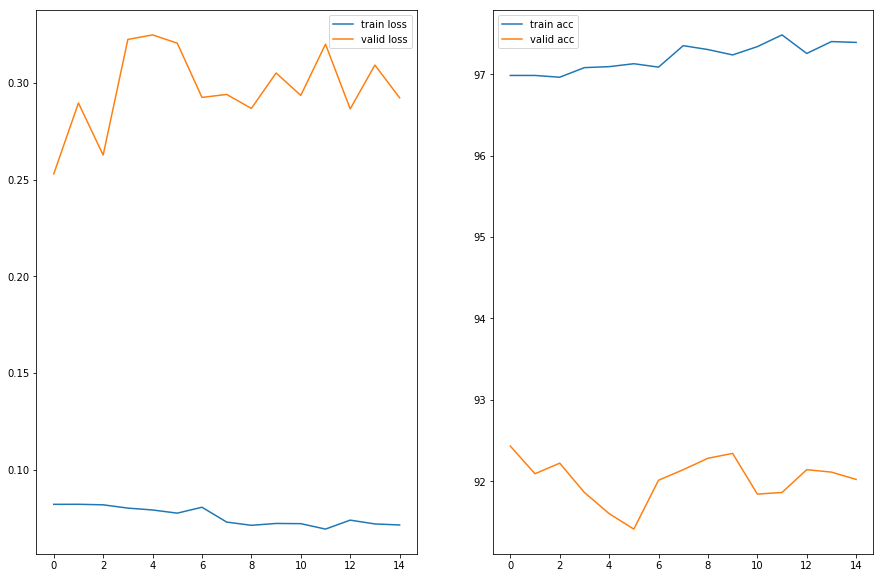

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train loss')
ax1.plot(mean_valid_losses, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(train_acc_list, label='train acc')
ax2.plot(valid_acc_list, label='valid acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

In [0]:
#checkpoint = torch.load('bestd.pth')
checkpoint = torch.load('bestd1.pth')
b_val_acc=checkpoint['best val acc']
b_val_loss=checkpoint['best val loss']
b_train_acc=checkpoint['best train acc']
b_train_loss=checkpoint['best train loss']

In [0]:
correct_te = 0
total_te = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted_v = torch.max(outputs.data, 1)
        correct_te += (predicted_v == labels).sum().item()
        total_te += labels.size(0)
accuracy_te = 100*correct_te/total_te
print(accuracy_te)


91.96


In [0]:
!cp '/content/datasetd.pth' '/content/drive/My Drive/datasetd.pth'

In [0]:
!cp '/content/dense.pth' '/content/drive/My Drive/dense.pth'

In [0]:
!cp '/content/dense1.pth' '/content/drive/My Drive/dense1.pth'

In [0]:
!cp '/content/bestd.pth' '/content/drive/My Drive/bestd.pth'

In [0]:
!cp '/content/bestd1.pth' '/content/drive/My Drive/bestd1.pth'